In [ ]:
!pip install --quiet optuna

In [ ]:
import optuna

optuna.__version__

'4.0.0'

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
SEED=1234
# Cargar el conjunto de datos
datos = pd.read_csv("/content/drive/MyDrive/Inteligencia Artificial/Temp_Asu20092021 (1).csv")

# Convertir la columna 'Fecha' al tipo datetime y establecerla como índice
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos.set_index('Fecha', inplace=True)

# Filtrar datos a partir de 2019
datos = datos[datos.index.year >= 2019]

# Eliminar filas con valores faltantes
datos.dropna(inplace=True)

# Calcular los percentiles 95, 50 (mediana) y 5 para cada día
percentiles_diarios = datos.resample('D')['Temperatura'].agg([lambda x: np.percentile(x, 95),
                                                              lambda x: np.percentile(x, 50),
                                                              lambda x: np.percentile(x, 5)])
percentiles_diarios.columns = ['Percentil_95', 'Mediana', 'Percentil_5']

# Desplazar para obtener los percentiles del siguiente día como variables objetivo
percentiles_diarios['Percentil_95_siguiente_dia'] = percentiles_diarios['Percentil_95'].shift(-1)
percentiles_diarios['Mediana_siguiente_dia'] = percentiles_diarios['Mediana'].shift(-1)
percentiles_diarios['Percentil_5_siguiente_dia'] = percentiles_diarios['Percentil_5'].shift(-1)

# Eliminar filas con valores faltantes
percentiles_diarios.dropna(inplace=True)

# Seleccionar características (por ejemplo,buscar variables adicionales)
X=percentiles_diarios[['Percentil_95','Mediana','Percentil_5']].values
y = percentiles_diarios[['Percentil_95_siguiente_dia','Mediana_siguiente_dia','Percentil_5_siguiente_dia']].values

# Escalar las características
scaler_X = StandardScaler()
X_escalado = scaler_X.fit_transform(X)

# Dividir datos en conjuntos de entrenamiento y validación
X_entrenamiento, X_validacion, y_entrenamiento, y_validacion = train_test_split(X_escalado, y, test_size=0.2, random_state=SEED, shuffle=False)


# Definir función objetivo para Optuna
def objetivo(trial):
    num_capas = 1
    tf.keras.utils.set_random_seed(SEED)

    num_capas = 1
    num_unidades = trial.suggest_categorical('num_unidades', [16, 32, 64])


    # Definir la arquitectura del modelo
    modelo = Sequential()
    modelo.add(Dense(num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
    for _ in range(num_capas - 1):
        modelo.add(Dense(num_unidades, activation='relu'))

    # Capa de salida para predecir los 3 percentiles (95, 50, 5)
    modelo.add(Dense(3, activation='linear'))

    # Compilar el modelo
    modelo.compile(optimizer=Adam(),
                   loss='mse',  # Para regresión, se usa 'mean squared error'
                   metrics=['mae'])  # Mean Absolute Error (MAE) para evaluación

    # Entrenar el modelo
    modelo.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=100, batch_size=256, verbose=0, shuffle=False)

    # Evaluar el modelo en el conjunto de validación
    _, val_mae = modelo.evaluate(X_validacion, y_validacion, verbose=0)

    return val_mae

# Realizar la optimización de hiperparámetros usando Optuna
estudio = optuna.create_study(direction='minimize')  # Minimizamos el MAE en lugar de maximizar
estudio.optimize(objetivo, n_trials=10)

# Obtener los mejores hiperparámetros
mejor_num_capas =  1
mejor_num_unidades = estudio.best_params['num_unidades']

print("Mejores Hiperparámetros:")
print("Número de Capas:", 1)
print("Número de Unidades:", mejor_num_unidades)



# Entrenar el modelo final usando los mejores hiperparámetros
modelo_final = Sequential()
modelo_final.add(Dense(mejor_num_unidades, activation='relu', input_shape=(X_entrenamiento.shape[1],)))
for _ in range(mejor_num_capas - 1):
    modelo_final.add(Dense(mejor_num_unidades, activation='relu'))
modelo_final.add(Dense(3, activation='linear'))

modelo_final.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss='mse',
                     metrics=['mae'])

# Entrenar el modelo final
historia = modelo_final.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_validacion, y_validacion), epochs=3000, batch_size=256, verbose=1, shuffle=False)

# Evaluar en conjunto de prueba
mae = modelo_final.evaluate(X_validacion, y_validacion, verbose=0)
print(f'MAE en validación: {mae}')

[I 2024-09-12 23:49:40,972] A new study created in memory with name: no-name-11fcfb49-1282-4669-9929-04f36e38e975
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

[I 2024-09-12 23:49:55,512] Trial 0 finished with value: 20.4274845123291 and parameters: {'num_unidades': 64}. Best is trial 0 with value: 20.4274845123291.
[I 2024-09-12 23:50:01,923] Trial 1 finished with value: 21.118589401245117 and parameters: {'num_unidades': 32}. Best is trial 0 with value: 20.4274845123291.
[I 2024-09-12 23:50:07,326] Trial 2 finished with value: 21.93014144897461 and parameters: {'num_unidades': 16}. Best is trial 0 with value: 20.4274845123291.
[I 2024-09-12 23:50:11,119] Trial 3 finished with value: 20.4274845123291 and parameters: {'num_unidades': 64}. Best is trial 0 with value: 20.42748

Streaming output truncated to the last 5000 lines.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.8303 - mae: 2.2431 - val_loss: 13.4912 - val_mae: 2.7164
Epoch 502/3000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.8278 - mae: 2.2427 - val_loss: 13.4866 - val_mae: 2.7159
Epoch 503/3000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.8253 - mae: 2.2422 - val_loss: 13.4820 - val_mae: 2.7154
Epoch 504/3000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.8228 - mae: 2.2417 - val_loss: 13.4774 - val_mae: 2.7150
Epoch 505/3000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.8204 - mae: 2.2412 - val_loss: 13.4728 - val_mae: 2.7145
Epoch 506/3000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 8.8180 - mae: 2.2408 - val_loss: 13.4683 - val_mae: 2.7140
Epoch 507/3000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 8.8155 - mae: 2.2403 - val_loss: 13.4638 - val_mae: 2.7136
Epoch 508/3000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 8.8130 - mae: 2.2398 - val_loss: 13.4594 - val_mae: 2.7131
Epoc

In [86]:
import matplotlib.pyplot as plt

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


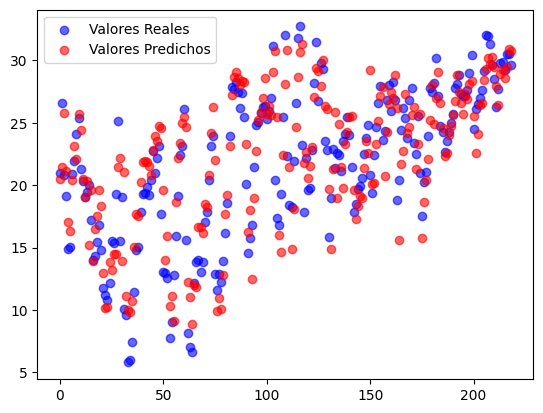

In [87]:
# Predecir usando el modelo final
y_pred = modelo_final.predict(X_validacion)

plt.scatter(range(len(y_validacion[:, 0])), y_validacion[:, 1], color='blue', label='Valores Reales', alpha=0.6)  # Valores reales (color azul)
plt.scatter(range(len(y_pred[:, 0])), y_pred[:, 1], color='red', label='Valores Predichos', alpha=0.6)  #Valores predichos (color rojo)
plt.legend()
plt.show()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


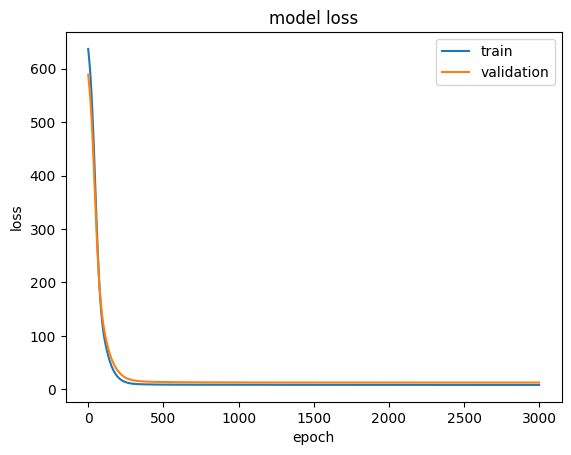

In [88]:
#Curva de aprendizaje
print(historia.history.keys())
plt.plot(historia.history['loss'])
plt.plot(historia.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [89]:
import optuna.visualization as vis

10 mejores resultados del estudio:
Trial #0, Valor MAE: 19.715669631958008, Hiperparámetros: {'num_unidades': 64}
Trial #42, Valor MAE: 19.79865837097168, Hiperparámetros: {'num_unidades': 64}
Trial #85, Valor MAE: 19.814912796020508, Hiperparámetros: {'num_unidades': 64}
Trial #36, Valor MAE: 19.822710037231445, Hiperparámetros: {'num_unidades': 64}
Trial #81, Valor MAE: 19.864809036254883, Hiperparámetros: {'num_unidades': 64}
Trial #44, Valor MAE: 19.89687156677246, Hiperparámetros: {'num_unidades': 64}
Trial #5, Valor MAE: 19.94205665588379, Hiperparámetros: {'num_unidades': 64}
Trial #27, Valor MAE: 19.96158790588379, Hiperparámetros: {'num_unidades': 64}
Trial #63, Valor MAE: 19.970474243164062, Hiperparámetros: {'num_unidades': 64}
Trial #89, Valor MAE: 19.97123146057129, Hiperparámetros: {'num_unidades': 64}


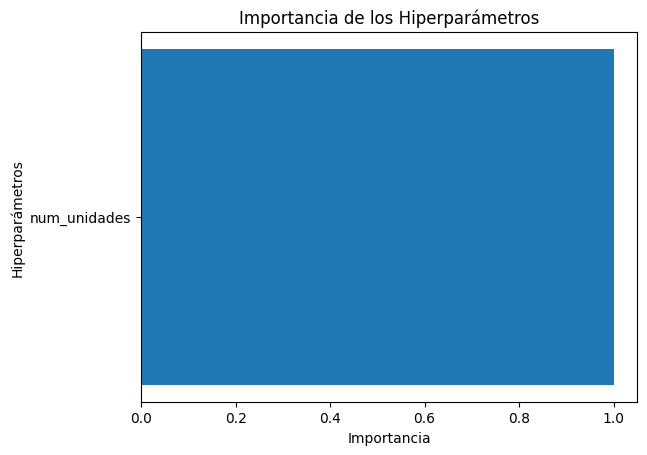

In [97]:
# Mostrar los 10 mejores resultados del estudio
print("10 mejores resultados del estudio:")
for trial in sorted(estudio.trials, key=lambda t: t.value)[:10]:
    print(f"Trial #{trial.number}, Valor MAE: {trial.value}, Hiperparámetros: {trial.params}")

# Mostrar la importancia de los hiperparámetros
importancia_hiperparametros = optuna.importance.get_param_importances(estudio)

# Graficar la importancia de los hiperparámetros
plt.barh(list(importancia_hiperparametros.keys()), list(importancia_hiperparametros.values()))
plt.xlabel('Importancia')
plt.ylabel('Hiperparámetros')
plt.title('Importancia de los Hiperparámetros')
plt.show()